In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/My_project

/content/drive/MyDrive/My_project


In [3]:
!pwd

/content/drive/MyDrive/My_project


In [4]:
!pip install docopt
!pip install TensorRT
!pip install unidecode

  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=f8452ac593ea77cdf27cb75653bf333fd463ca739f067da8c97bb8aa5d317aee
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
  Preparing metadata (setup.py) ... done
  Created wheel for TensorRT: filename=tensorrt-8.6.1.post1-py2.py3-none-any.whl size=17281 sha256=02b6f49a88c6b7c57f32e3345e2262719547ecbb0d75441f8d5d1f4126bb68bf
  Stored in directory: /root/.cache/pip/wheels/f4/c8/0e/b79b08e45752491b9acfdbd69e8a609e8b2ed7640dda5a3e59
Successfully built TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 1.8 MB/s eta 0:00:00


In [5]:
!pip uninstall numpy
!pip install numpy==1.23.0

Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.25.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 43.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.0 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; pyth

In [1]:
!pip uninstall librosa
!pip install librosa==0.9.1

Found existing installation: librosa 0.10.1
Uninstalling librosa-0.10.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/librosa-0.10.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/librosa/*
Proceed (Y/n)? y
  Successfully uninstalled librosa-0.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.1/213.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.7 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
%pylab inline
rcParams["figure.figsize"] = (10,5)

import os
import sys
import numpy as np
import librosa
sys.path.append('/content/drive/MyDrive/My_project/pytorch-dc-tts')
sys.path.append('/content/drive/MyDrive/My_project/pytorch-dc-tts/models')
sys.path.append("/content/drive/MyDrive/My_project/tacotron_pytorch")
sys.path.append("/content/drive/MyDrive/My_project/tacotron_pytorch/lib/tacotron")

# For the DC-TTS
import torch
from text2mel import Text2Mel
from ssrn import SSRN
from audio import save_to_wav, spectrogram2wav
from utils import get_last_checkpoint_file_name, load_checkpoint_test, save_to_png, load_checkpoint
from datasets.emovdb import vocab, get_test_data
import librosa.display
import matplotlib.pyplot as plt
import ipywidgets as widgets

from text import text_to_sequence, symbols
# from util import audio

from tacotron_pytorch import Tacotron
from synthesis import tts as _tts

# For Audio/Display purposes
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import display
from google.colab import widgets
from google.colab import output
import warnings
warnings.filterwarnings('ignore')


torch.set_grad_enabled(False)
text2mel = Text2Mel(vocab).eval()

ssrn = SSRN().eval()
load_checkpoint('/content/drive/MyDrive/My_project/trained_models/ssrn.pth', ssrn, None)

model = Tacotron(n_vocab=len(symbols),
                 embedding_dim=256,
                 mel_dim=80,
                 linear_dim=1025,
                 r=5,
                 padding_idx=None,
                 use_memory_mask=False,
                 )

def visualize(alignment, spectrogram, Emotion, fs=22050, hop_length=512):
    label_fontsize = 16
    tb = widgets.TabBar(['Alignment', 'Spectrogram'], location='top')

    with tb.output_to('Alignment'):
        plt.imshow(alignment.T, aspect="auto", origin="lower", interpolation=None)
        plt.xlabel("Decoder timestamp", fontsize=label_fontsize)
        plt.ylabel("Encoder timestamp", fontsize=label_fontsize)

    with tb.output_to('Spectrogram'):
        if Emotion in ['Disgust', 'Amused', 'Sleepiness']:
            librosa.display.specshow(spectrogram.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
        else:
            librosa.display.specshow(spectrogram, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")

        plt.xlabel("Time", fontsize=label_fontsize)
        plt.ylabel("Hz", fontsize=label_fontsize)
        plt.xlim(0, 1)



def tts_dctts(text2mel, ssrn, text):
  sentences = [text]

  max_N = len(text)
  L = torch.from_numpy(get_test_data(sentences, max_N))
  zeros = torch.from_numpy(np.zeros((1, 80, 1), np.float32))
  Y = zeros
  A = None

  for t in range(1000):
      _, Y_t, A = text2mel(L, Y, monotonic_attention=True)
      Y = torch.cat((zeros, Y_t), -1)
      _, attention = torch.max(A[0, :, -1], 0)
      attention = attention.item()
      if L[0, attention] == vocab.index('E'):  # EOS
          break

  _, Z = ssrn(Y)
  Y = Y.cpu().detach().numpy()
  A = A.cpu().detach().numpy()
  Z = Z.cpu().detach().numpy()

  return spectrogram2wav(Z[0, :, :].T), A[0, :, :], Y[0, :, :]


def tts_tacotron(model, text):
    waveform, alignment, spectrogram = _tts(model, text)
    return waveform, alignment, spectrogram

def present(waveform, Emotion, figures=False):
  if figures!=False:
        visualize(figures[0], figures[1], Emotion)
  IPython.display.display(Audio(waveform, rate=fs))


fs = 20500 #20000
hop_length = 1000
model.decoder.max_decoder_steps = 200

Populating the interactive namespace from numpy and matplotlib
/content/drive/MyDrive/My_project/trained_models/ssrn.pth
loaded checkpoint epoch=0 step=0


Populating the interactive namespace from numpy and matplotlib
/content/drive/MyDrive/My_project/trained_models/angry_dctts.pth
loaded checkpoint epoch=375 step=3000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

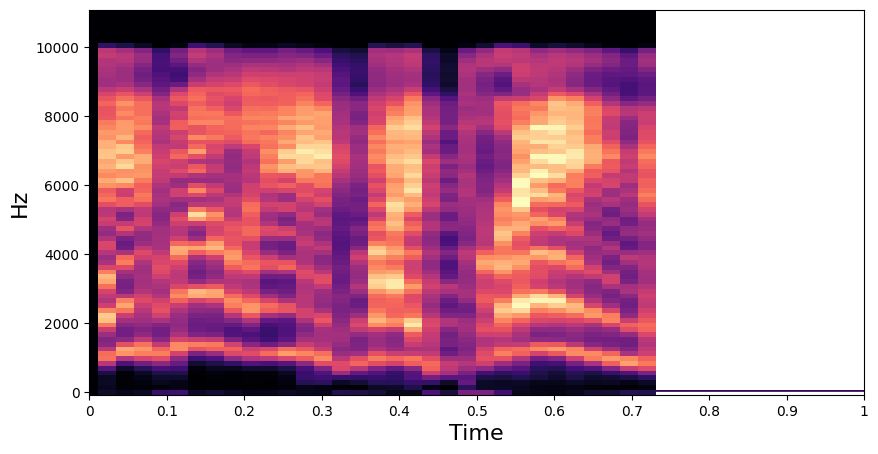

In [6]:

%pylab inline

Emotion = "Angry" #@param ["Neutral", "Angry", "Disgust", "Sleepiness"]
Text = 'He will eat my brain ' #@param {type:"string"}

wav, align, mel = None, None, None

if Emotion == "Neutral":
  load_checkpoint('/content/drive/MyDrive/My_project/trained_models/'+Emotion.lower()+'_dctts.pth', text2mel, None)
  wav, align, mel = tts_dctts(text2mel, ssrn, Text)
elif Emotion == "Angry":
  load_checkpoint_test('/content/drive/MyDrive/My_project/trained_models/'+Emotion.lower()+'_dctts.pth', text2mel, None)
  wav, align, mel = tts_dctts(text2mel, ssrn, Text)
  # wav = wav.T
elif Emotion == "Disgust" or Emotion == "Sleepiness":
  checkpoint = torch.load('/content/drive/MyDrive/My_project/trained_models/'+Emotion.lower()+'_tacotron.pth', map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint["state_dict"])
  wav, align, mel = tts_tacotron(model, Text)

present(wav, Emotion, (align,mel))

